# Diabetes Dataset
This dataset was used in https://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf
by Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani, in Annals of Statistics (2004).

As part of the activities in _MCZA015 - 13_ in Universidade Federal do ABC(UFABC) in 2019.

Some general ideas to approach the problem:

   - OK - y relation to prediction is linear? necessary to add polynomial features?
   - OK - try to add more atributes to model
   - OK - use CV to compare different models
   - OK - Try fitting model without and with RIDGE
   - OK - check for corr between atributes to look for colinearity
   - OK - do models suffer degradation for test?
   - OK - is test and train cv ordering of models similar?



A dataset that at first glance is clean and presents no null values.
Atributes such as 'age', 'bmi', 'map' seem adequate.
'Sex' shows by the mean that there are more of sex '1'.

'y' represents how critical is each patient's case. lower: better, higher: worse.



In [171]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression,Ridge
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.pipeline import make_pipeline

get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [172]:
df = pd.read_csv("diabetes.csv")

In [3]:
df.head()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,y
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


In [4]:
df.describe()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,y
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,48.518100,1.468326,26.375792,94.647014,189.140271,115.439140,49.788462,4.070249,545.984142,91.260181,152.133484
std,13.109028,0.499561,4.418122,13.831283,34.608052,30.413081,12.934202,1.290450,1526.681506,11.496335,77.093005
min,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000,25.000000
25%,38.250000,1.000000,23.200000,84.000000,164.250000,96.050000,40.250000,3.000000,4.290500,83.250000,87.000000
50%,50.000000,1.000000,25.700000,93.000000,186.000000,113.000000,48.000000,4.000000,4.695900,91.000000,140.500000
75%,59.000000,2.000000,29.275000,105.000000,209.750000,134.500000,57.750000,5.000000,5.141700,98.000000,211.500000
max,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6107.000000,124.000000,346.000000


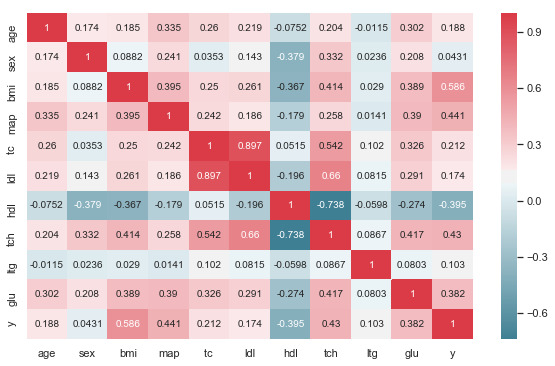

In [5]:
plt.figure(figsize=(10,6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.corr(),annot=True, fmt='.3g',cmap=cmap)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001243C8B8240>,
      dtype=object)

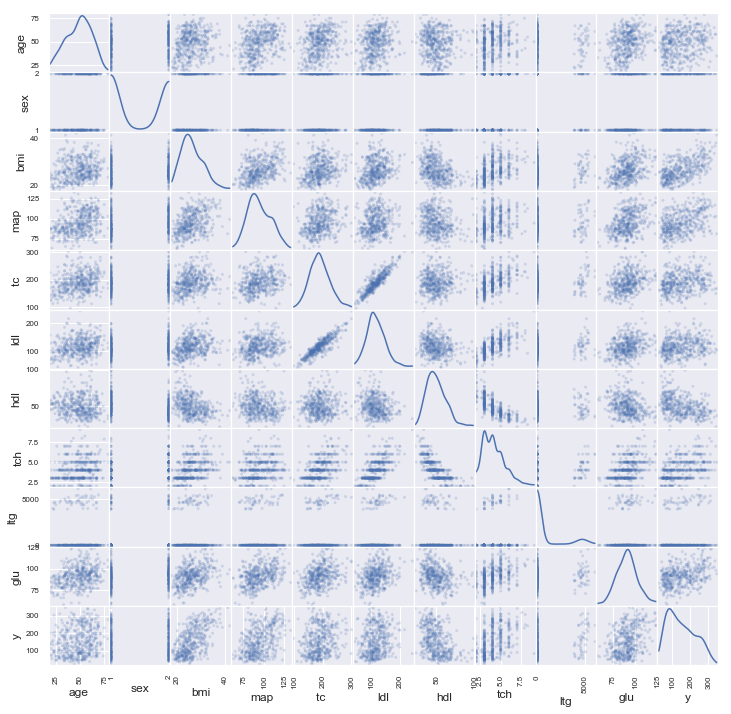

In [6]:
from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha = 0.2, figsize = (12, 12), diagonal = 'kde')

__Podemos remover a ldl pois apresenta baixa correlação com 'y', ao mesmo tempo que apresenta alta correlação com tc (0.87) e tch (0.65)__

In [5]:
a = df[df['ltg']<1000]['ltg']
b = df[df['ltg']<1000]['y']
c = df[df['ltg']>1000]['ltg']
d = df[df['ltg']>1000]['y']

print('For ltg < 1000 the corr with y is: {:.3f}.\nFor ltg > 1000 the corr with y is: {:.3f}.'.format(a.corr(b),c.corr(d)))
print('\nKurtosis: {:.3f}. Skewness : {:.3f}.'.format(df['ltg'].kurtosis(),df['ltg'].skew()))

For ltg < 1000 the corr with y is: 0.573.
For ltg > 1000 the corr with y is: 0.472.

Kurtosis: 4.443. Skewness : 2.509.


**Enquanto a correlação de *'ltg' com 'y' é baixa(.103)*, a correlação de cada um dos grupos (na casa das unidades e na casa dos milhares) parece ser consideravelmente mais forte *(0.573 valores baixos e .472 valores altos)*.**

**No scatter-matrix é claro que existem valores altos e baixos de 'y' para valores altos e baixos de *'ltg'*. Checando *skewness e kurtosis* os valores também não contribuem para a conclusão de que esta variável deva ser usada do jeito que se encontra.**

_Para se investigar a variável **'ltg'** criou-se uma coluna binária **('hiltg')** onde '1' significa que determinada observação apresenta **'ltg'** na casa dos milhares. Afim de entender se a discretização desta característica poderia ser uma melhor característica para o modelo._

In [173]:
df['hiltg'] = 0
for rw in range(df.shape[0]):
    if df['ltg'][rw]> 1000:
        df['hiltg'][rw] = 1

C:\Users\Bronze\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


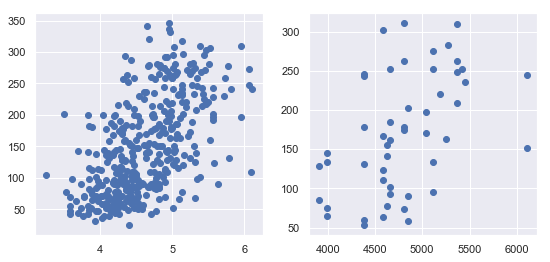

In [174]:
plt.figure(figsize=(9,9))
plt.subplot(221)
plt.scatter(df[df['hiltg']==0]['ltg'],df[df['hiltg']==0]['y'])
plt.subplot(222)
plt.scatter(df[df['hiltg']==1]['ltg'],df[df['hiltg']==1]['y'])

**O gráfico de dispersão evidencia a correlação calculada anteriormente dentro de cada um dos grupos. Ou seja, o 'y' até certo ponto é sensível ao aumento de 'ltg' em cada grupo separadamente. Uma possibilidade plausível seria uma confusão nas unidades e inserção de valores de 3 ordens de grandeza maiores (i.e.: microgramas e miligramas). Supondo que os valores dos milhares fossem divididos por 1000 eles encaixariam adequadamente no conjunto das unidades. Apesar disso, manipular esta variável sem ter contato com experts da área não é indicado, então deixaremos como está.**

**A característica *'sex'* apresenta fraca correlação com 'y' enquanto é correlacionada com *'hdl' negativamente (-0.379) e tch  positivamente (0.332)*. Deixá-la de lado a priori pode melhorar o modelo.**

**'ldl' apresenta forte correlação com *'tc' (0.897)* sendo assim colineares e portanto possíveis candidatas a serem eliminadas do modelo final.**

## Definindo funções para regressão

In [175]:
def poly_reg(DATA,degree,columns,shuf):
    X_train,X_test,y_train,y_test = train_test_split(
        DATA[columns],DATA['y'],test_size=0.3,shuffle=shuf)

    poli_model = make_pipeline(PolynomialFeatures(degree),LinearRegression(fit_intercept=True))
    
    poli_model.fit(X_train,y_train)

    y_pred = poli_model.predict(X_train)
    
    print("R^2 em todo o conjunto de treino:", r2_score(y_train, y_pred))
    
    eval_score = cross_val_score(poli_model,X_train,y_train,scoring='r2',cv=10)
    score_t = r2_score(y_test,poli_model.predict(X_test))
    
    #residuos = y_train - y_pred
    #plt.scatter(y_train, residuos)
    print('Train - Linear Regression CV médio:',np.mean(eval_score))
    print('Test - Linear Regression R2 score:',np.mean(score_t),'\n')
    print(list(zip(poli_model.named_steps['linearregression'].coef_[1:],X_train[columns])))
    return 

In [176]:
def ridge_reg(data,deg,cols,shuf):
    X_train,X_test,y_train,y_test = train_test_split(
        data[cols],data['y'],test_size=0.3,shuffle=shuf)

    poli_model_r = make_pipeline(PolynomialFeatures(deg), Ridge(fit_intercept=True, alpha=50))
    
    poli_model_r.fit(X_train,y_train)

    y_pred_r = poli_model_r.predict(X_train)

    print("R^2 em todo o conjunto de treino:", r2_score(y_train,y_pred_r))
    
    eval_score_r = cross_val_score(poli_model_r,X_train,y_train,scoring='r2',cv=10)
    score_test = r2_score(y_test,poli_model_r.predict(X_test))
    
    #residuos_r = y_train - y_pred_r
    #plt.scatter(y_train, residuos_r)
    print('Train - Ridge Regression CV médio:',np.mean(eval_score_r))
    print('Test - Ridge Regression R2_score:',np.mean(score_test),'\n')
    print(list(zip(poli_model_r.named_steps['ridge'].coef_[1:],X_train[cols])))
    return 

In [178]:
print(poly_reg(df,1,df.columns.difference(['y']),False),'\n')
print('-'*80)
print(ridge_reg(df,1,df.columns.difference(['y']),False))

R^2 em todo o conjunto de treino: 0.5019170200303766
Train - Linear Regression CV médio: 0.40343821718124884
Test - Linear Regression R2 score: 0.461029861507534 

[(0.05937079535248545, 'age'), (6.235001517424879, 'bmi'), (0.4884862251622059, 'glu'), (-2.3149390980169056, 'hdl'), (106.78789736671119, 'hiltg'), (-1.8310536397215753, 'ldl'), (-0.020503541512876613, 'ltg'), (1.021340436297625, 'map'), (-27.376139175874396, 'sex'), (1.5321420009953197, 'tc '), (6.272974366834104, 'tch')]
None 

--------------------------------------------------------------------------------
R^2 em todo o conjunto de treino: 0.49450088100778355
Train - Ridge Regression CV médio: 0.4021947552283405
Test - Ridge Regression R2_score: 0.48068298442615676 

[(-0.0047925917458321084, 'age'), (6.348085148852738, 'bmi'), (0.4632246278458414, 'glu'), (-2.3178666728245383, 'hdl'), (0.7613918272354249, 'hiltg'), (-1.7571356625051875, 'ldl'), (0.0015689969800143412, 'ltg'), (0.9361944253244439, 'map'), (-14.6143121320

In [198]:
print(poly_reg(df,1,df.columns.difference(['y']),True),'\n')
print('-'*80)
print(ridge_reg(df,1,df.columns.difference(['y']),True))

R^2 em todo o conjunto de treino: 0.5363824969731126
Train - Linear Regression CV médio: 0.44586330470685603
Test - Linear Regression R2 score: 0.3845919610480083 

[(0.0286460975967427, 'age'), (6.39830893697847, 'bmi'), (0.28020816377186286, 'glu'), (-2.3037397843615457, 'hdl'), (-19.817384418162185, 'hiltg'), (-1.5972290396223519, 'ldl'), (0.005592399562932181, 'ltg'), (1.107479063472388, 'map'), (-21.71147452724679, 'sex'), (1.4598044001404302, 'tc '), (1.4191707702436582, 'tch')]
None 

--------------------------------------------------------------------------------
R^2 em todo o conjunto de treino: 0.46383394659523836
Train - Ridge Regression CV médio: 0.37141158482422476
Test - Ridge Regression R2_score: 0.5394080894597963 

[(-0.013722040709623042, 'age'), (5.86055172019881, 'bmi'), (0.23698885102756143, 'glu'), (-1.880049288496054, 'hdl'), (0.5303120692084473, 'hiltg'), (-1.2958230468512746, 'ldl'), (0.0026917761303575116, 'ltg'), (1.254939473047451, 'map'), (-13.0025728666629

*Testando sem e com a variável **'hiltg'** entre as preditas.*

In [200]:
poly_reg(df,1,df.columns.difference(['age','hiltg','sex','tc ','ltg','y']),False) #sem hiltg
print('-'*80)
poly_reg(df,1,df.columns.difference(['age','sex','tc ','ltg','y']),False) #com hiltg

R^2 em todo o conjunto de treino: 0.4383142274666252
Train - Linear Regression CV médio: 0.3593240122071256
Test - Linear Regression R2 score: 0.48203339922183974 

[(7.286258049555968, 'bmi'), (0.5938091515241851, 'glu'), (0.1504087841537331, 'hdl'), (-0.5974263078934884, 'ldl'), (1.094042396631562, 'map'), (20.037963149421536, 'tch')]
--------------------------------------------------------------------------------
R^2 em todo o conjunto de treino: 0.4431476167644369
Train - Linear Regression CV médio: 0.36024762464745885
Test - Linear Regression R2 score: 0.485601143933433 

[(7.333603933398948, 'bmi'), (0.5780260940088217, 'glu'), (0.16456480974888862, 'hdl'), (16.886248363812754, 'hiltg'), (-0.6164501482237819, 'ldl'), (1.0983283915203677, 'map'), (20.325021503949795, 'tch')]


__Voltando a análise anterior, buscaram-se melhores preditores manualmente. As preditoras 'bmi', 'map', 'ldl', 'hdl' e 'glu' parecem bons candidatos a predição, apresentando valores positivos ainda que baixos individualmente (validação cruzada R2).
Ao realizar regressão retirando 'age','sex','tc ' e 'ltg' obtem-se um R2 de *0.3593*__

__Podemos observar que a avaliação melhora um pouco *(.3602)* com a introdução desta nova característica ('hiltg'). Os gráficos de dispersão corroboram as correlações calculadas anteriormente.__

_Importante lembrar que estamos introduzindo uma variável binária discretizando em grupos com valores altos e baixos de 'ltg' no lugar de utilizar os valores contínuos absolutos. Isso pode afetar o modelo enviesando-o._

__Testando abaixo a transformação de apenas algumas características em polinomiais__

In [233]:

X_train,X_test,y_train,y_test = train_test_split(
        df[df.columns.difference(['y'])],df['y'],test_size=0.3,shuffle=True)


def transf(grau,X,cols):
    poli = PolynomialFeatures(grau, include_bias=False)
    x_poli = poli.fit_transform(X[cols])
    return x_poli

second_order = transf(2,X_train,['hdl','glu'])
fifth_order = transf(5,X_train,['tch'])

ppoli = PolynomialFeatures(1, include_bias=False)
xx_poli=  ppoli.fit_transform(X_train[X_train.columns.difference(['hdl','glu','tch'])])
xxx = np.append(xx_poli,second_order,axis=1)
xxx = np.append(xxx,fifth_order,axis=1)

poli_model = LinearRegression(fit_intercept=True)
poli_model.fit(xxx, y_train)

scores = cross_val_score(poli_model,
                         xxx,y_train, scoring="r2", cv=10)

se = transf(2,X_test,['hdl','glu'])
fi = transf(5,X_test,['tch'])

pp = PolynomialFeatures(1, include_bias=False)
xx_poli=  pp.fit_transform(X_test[X_test.columns.difference(['hdl','glu','tch'])])
xxx2 = np.append(xx_poli,se,axis=1)
xxx2 = np.append(xxx2,fi,axis=1)

scores_t = r2_score(y_test,poli_model.predict(xxx2))

#y_pred_p = poli_model.predict(xxx)
#residuos_r = y_train - y_pred_p
#plt.scatter(y_train, residuos_r)
print('Train - Linear Regression CV médio: {:.4f}'.format(np.mean(scores)))
print('\nNeste exemplo hdl, glu foram transformadas em 2º grau e tch em 5º.')

Train - Linear Regression CV médio: 0.4222

Neste exemplo hdl, glu foram transformadas em 2º grau e tch em 5º.


## Conclusão

 - Investigando a fundo descobriu-se que alguns atributos podem ser retirados sem dano ao modelo considerável. Como pode ser visto no caso da regressão linear, o score do conjunto de teste chega a .4610. No caso da Ridge chega-se a 0.4806.__

 - Enquanto na Regressão Linear uma busca iterativa é necessária para melhora do modelo, na Ridge o termo de penalização reduz o efeito de atributos de forma autônoma. O que pode ser observado nos coeficientes de 'sex','age' e'tch' principalmente.
 
 - É notável que os modelos apresentados parecem generalizar bem. R2_scores para o treino por volta de .50, CV  de aproximadamente 0.40 e para o conjunto de teste ficando acima de .46 em ambos (Linear/Ridge).
 
 - Quando é passado True para Shuffle pode-se observar que ao realizar algumas iterações o score varia consideravelmente. Em alguns casos chegando a 0.53 em outro baixando para menos de 0.30. Os dados estão tabelados de tal forma que diferentes porções podem contribuir consideravelmente diversas para o modelo final.

In [252]:
poly_reg(df,1,df.columns.difference(['y']),True) #sem hiltg
#hdl 2
#tch 5
#glu 2


R^2 em todo o conjunto de treino: 0.4820092283985865
Train - Linear Regression CV médio: 0.40168852482265505
Test - Linear Regression R2 score: 0.5047773176386452 

[(0.06970422196201834, 'age'), (5.6223792600270475, 'bmi'), (0.5846114818768181, 'glu'), (-1.7251421159466955, 'hdl'), (-120.18265370318137, 'hiltg'), (-0.9770600260489141, 'ldl'), (0.029209418078053363, 'ltg'), (1.0617386958204755, 'map'), (-18.940890255405094, 'sex'), (0.8437328857346036, 'tc '), (6.723352037040241, 'tch')]
